# This notebooks implements MLForecast and the module MLForecast_Evaluator developed for another sales time series forecasting project to forecast world and continents emissions from agrifood systems up to 2030 

In [230]:
import math
import random
from datetime import date
import warnings
from typing import List, Optional

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from mlforecast import MLForecast
from mlforecast.lag_transforms import ExpandingMean, RollingMean, ExpandingStd, ExponentiallyWeightedMean
from mlforecast.target_transforms import Differences, LocalStandardScaler, GlobalSklearnTransformer
from mlforecast.feature_engineering import transform_exog
from utilsforecast.feature_engineering import fourier, trend, pipeline
from mlforecast.utils import PredictionIntervals

from numba import njit
from scipy import stats
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler, RobustScaler, FunctionTransformer, OneHotEncoder, TargetEncoder

from sklearn.linear_model import LinearRegression
from window_ops.shift import shift_array

from xgboost import XGBRegressor
from catboost import CatBoostRegressor


# Suppress warnings
warnings.filterwarnings('ignore')

## Import MLForecast_Evaluator and helper functions:

In [231]:
import sys
import os

# Get the parent directory
parent_dir = os.path.abspath(os.path.join(os.getcwd(), os.pardir))

# Add the parent directory to the system path
if parent_dir not in sys.path:
    sys.path.append(parent_dir)

# Now you can import the Evaluator class
from fao_utils import MLForecast_Evaluator, query_country, load_fao_table

# Load data and preprocess it

In [232]:
data = pd.read_parquet(r'../data/FAOSTAT/clean_data/all_tables_processed/full_country_dataset_v4_TOTALS.parquet')

### Select only World and continents

In [233]:
selected_regions = [5000, 5100, 5203, 5207, 5300, 5400, 5500]
data = data[data['Area Code'].isin(selected_regions)]
data = data[data['Year'] > 1990]

In [234]:
data.Area.unique()

array(['World', 'Africa', 'Northern America', 'South America', 'Asia',
       'Europe', 'Oceania'], dtype=object)

### Load population table

Only complete projected feature by FAO. Will use this as an exogenous feature

In [235]:
projections = load_fao_table(path='../data/FAOSTAT/all_raw', table_number=58)

In [236]:
# Also select only continents and "world" region
projections = projections[projections['Area Code'].isin(selected_regions)] 

In [237]:
projections = projections[projections['Element'] == 'Total Population - Both sexes']

In [238]:
selected_columns = ['Area Code', 'Area', 'Year', 'Value']
projections = projections[selected_columns].rename(columns={'Value': 'population_1000s'})

### Select FORECASTING TARGET:

In [239]:
target = "Agrifood_systems_Emissions_(CO2eq)_(AR5)_kt"

In [240]:
data = data.rename(columns={"Area": "unique_id", "Year": "ds", 
                            target: "y",
                            "Population_-_Est._&_Proj._Total_Population_-_Both_sexes_1000_No": "population_1000s"})

cols = ["unique_id", "ds", "y", "population_1000s"]
data = data[cols].dropna()

In [241]:
# Will test on "Total_Energy_Emissions_(CO2)_kt"
projections = projections.rename(columns={"Area": "unique_id", "Year": "ds"})

cols = ["unique_id", "ds", "population_1000s"]
projections = projections[cols].dropna()

### Train/Validation Split

In [242]:
train_index = sorted(list(data["ds"].unique()))[:-5]
valid_index = sorted(list(data["ds"].unique()))[-5:] # Last 5 years for validation

In [243]:
train = data.loc[data['ds'].isin(train_index)]
valid = data.loc[data['ds'].isin(valid_index)]
valid.sample(5)

,unique_id,ds,y,population_1000s
8379,Europe,2017,2.011256e+06,744449.362
8188,Asia,2018,6.859154e+06,4590021.498
7806,World,2020,1.603626e+07,7840952.880
7804,World,2018,1.613419e+07,7683789.830
7839,Africa,2021,2.849113e+06,1393676.446


In [244]:
# XGBRegressor
xgb = XGBRegressor(
    n_estimators=150,
    max_depth=5,
    reg_lambda=0.5,
    reg_alpha=0.5,
    random_state=42
)

# CatBoostRegressor
cb = CatBoostRegressor(
    iterations=100,
    depth=5,
    l2_leaf_reg=1,
    random_seed=42,
    silent=True
)

# List of models
models = [xgb, cb]

## Create target lags and lag transformations

In [253]:
@njit
def ratio_over_previous(x, offset=1):
    """Computes the ratio between the current value and its `offset` lag"""
    return x / shift_array(x, offset=offset)

@njit
def diff_over_previous(x, offset=1):
    """Computes the difference between the current value and its `offset` lag"""
    return x - shift_array(x, offset=offset)

sk_log1p = FunctionTransformer(func=np.log1p, inverse_func=np.expm1)

fcst = MLForecast(
    models=models,
    freq=1,
    lags=[1,2,3],
    lag_transforms={
        1: [
            RollingMean(window_size=3),
            ExpandingMean(),
            ExponentiallyWeightedMean(alpha=0.7), #Higher alpha gives more importance to recent years
            ExpandingStd(),
            ratio_over_previous, (ratio_over_previous, 2),
            diff_over_previous, (diff_over_previous, 2)
            ],
        2: [
            RollingMean(window_size=3),
            ExpandingMean(),
            ExponentiallyWeightedMean(alpha=0.7), #Higher alpha gives more importance to recent years
            ExpandingStd(),
            ratio_over_previous, (ratio_over_previous, 2),
            diff_over_previous, (diff_over_previous, 2)
            ],
        3: [
            RollingMean(window_size=3),
            ExpandingMean(),
            ExponentiallyWeightedMean(alpha=0.8), #Higher alpha gives more importance to recent years
            ExpandingStd(),
            ],
    },
    # target_transforms=[GlobalSklearnTransformer(sk_log1p), Differences([1])],

    num_threads=6
)

We are predicting target log differences:

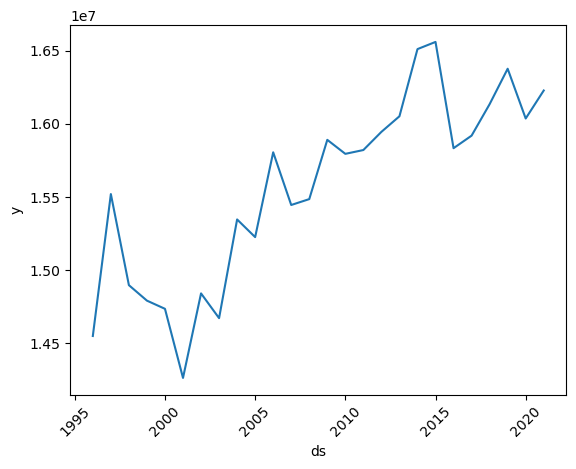

,unique_id,ds,y,population_1000s,lag1,lag2,lag3,rolling_mean_lag1_window_size3,expanding_mean_lag1,exponentially_weighted_mean_lag1_alpha0.7,...,exponentially_weighted_mean_lag2_alpha0.7,expanding_std_lag2,ratio_over_previous_lag2,ratio_over_previous_lag2_offset2,diff_over_previous_lag2,diff_over_previous_lag2_offset2,rolling_mean_lag3_window_size3,expanding_mean_lag3,exponentially_weighted_mean_lag3_alpha0.8,expanding_std_lag3
7782,World,1996,1.455002e+07,5825145.290,1.464567e+07,1.439022e+07,1.427699e+07,1.443763e+07,1.437616e+07,1.455897e+07,...,1.435666e+07,54597.875941,1.007931,1.007853,113225.7381,112123.9251,1.428164e+07,1.428164e+07,1.427768e+07,7123.555935
7783,World,1997,1.551977e+07,5906481.265,1.455002e+07,1.464567e+07,1.439022e+07,1.452864e+07,1.440514e+07,1.455271e+07,...,1.455897e+07,157907.401779,1.017752,1.025824,255459.8004,368685.5385,1.431510e+07,1.430878e+07,1.436771e+07,54597.875941
7784,World,1998,1.489745e+07,5987312.479,1.551977e+07,1.455002e+07,1.464567e+07,1.490516e+07,1.456437e+07,1.522965e+07,...,1.455271e+07,158068.864735,0.993469,1.011105,-95650.9960,159808.8044,1.443763e+07,1.437616e+07,1.459008e+07,157907.401779
7785,World,1999,1.479167e+07,6067758.458,1.489745e+07,1.551977e+07,1.455002e+07,1.498908e+07,1.460601e+07,1.499711e+07,...,1.522965e+07,445315.963721,1.066649,1.059683,969742.6739,874091.6779,1.452864e+07,1.440514e+07,1.455804e+07,158068.864735
7786,World,2000,1.473578e+07,6148898.973,1.479167e+07,1.489745e+07,1.551977e+07,1.506963e+07,1.462664e+07,1.485330e+07,...,1.499711e+07,428770.832633,0.959902,1.023878,-622317.0933,347425.5806,1.490516e+07,1.456437e+07,1.532742e+07,445315.963721


In [254]:
transformed_data = fcst.preprocess(data, static_features=[])
query_country(transformed_data, unique_id ="World", target_col="y").head()

In [255]:
# Correlation to target
transformed_data.drop(columns=['unique_id', 'ds']).corr()['y'].sort_values(ascending=False)

y                                            1.000000
exponentially_weighted_mean_lag1_alpha0.7    0.999042
rolling_mean_lag1_window_size3               0.998930
lag1                                         0.998896
exponentially_weighted_mean_lag2_alpha0.7    0.998701
lag2                                         0.998632
rolling_mean_lag2_window_size3               0.998503
exponentially_weighted_mean_lag3_alpha0.8    0.998159
rolling_mean_lag3_window_size3               0.998103
lag3                                         0.998062
expanding_mean_lag1                          0.997315
expanding_mean_lag2                          0.997135
expanding_mean_lag3                          0.996941
population_1000s                             0.962039
expanding_std_lag1                           0.788500
expanding_std_lag2                           0.770070
expanding_std_lag3                           0.748352
diff_over_previous_lag2_offset2              0.233293
diff_over_previous_lag1_offs

## Create future df with forecast population for prediction

In [256]:
future_df = pd.concat([valid, projections]).drop('y', axis=1)
future_df = valid.drop('y', axis=1)
future_df.head()

,unique_id,ds,population_1000s
7803,World,2017,7599822.416
7804,World,2018,7683789.830
7805,World,2019,7764951.042
7806,World,2020,7840952.880
7807,World,2021,7909295.146


# Train and evaluate

In [257]:
# train = train.drop("population_1000s", axis=1)
fcst.fit(train, fitted=True, static_features=[],
    prediction_intervals=PredictionIntervals(n_windows=3, h=5, method="conformal_distribution"))

MLForecast(models=[XGBRegressor, CatBoostRegressor], freq=1, lag_features=['lag1', 'lag2', 'lag3', 'rolling_mean_lag1_window_size3', 'expanding_mean_lag1', 'exponentially_weighted_mean_lag1_alpha0.7', 'expanding_std_lag1', 'ratio_over_previous_lag1', 'ratio_over_previous_lag1_offset2', 'diff_over_previous_lag1', 'diff_over_previous_lag1_offset2', 'rolling_mean_lag2_window_size3', 'expanding_mean_lag2', 'exponentially_weighted_mean_lag2_alpha0.7', 'expanding_std_lag2', 'ratio_over_previous_lag2', 'ratio_over_previous_lag2_offset2', 'diff_over_previous_lag2', 'diff_over_previous_lag2_offset2', 'rolling_mean_lag3_window_size3', 'expanding_mean_lag3', 'exponentially_weighted_mean_lag3_alpha0.8', 'expanding_std_lag3'], date_features=[], num_threads=6)

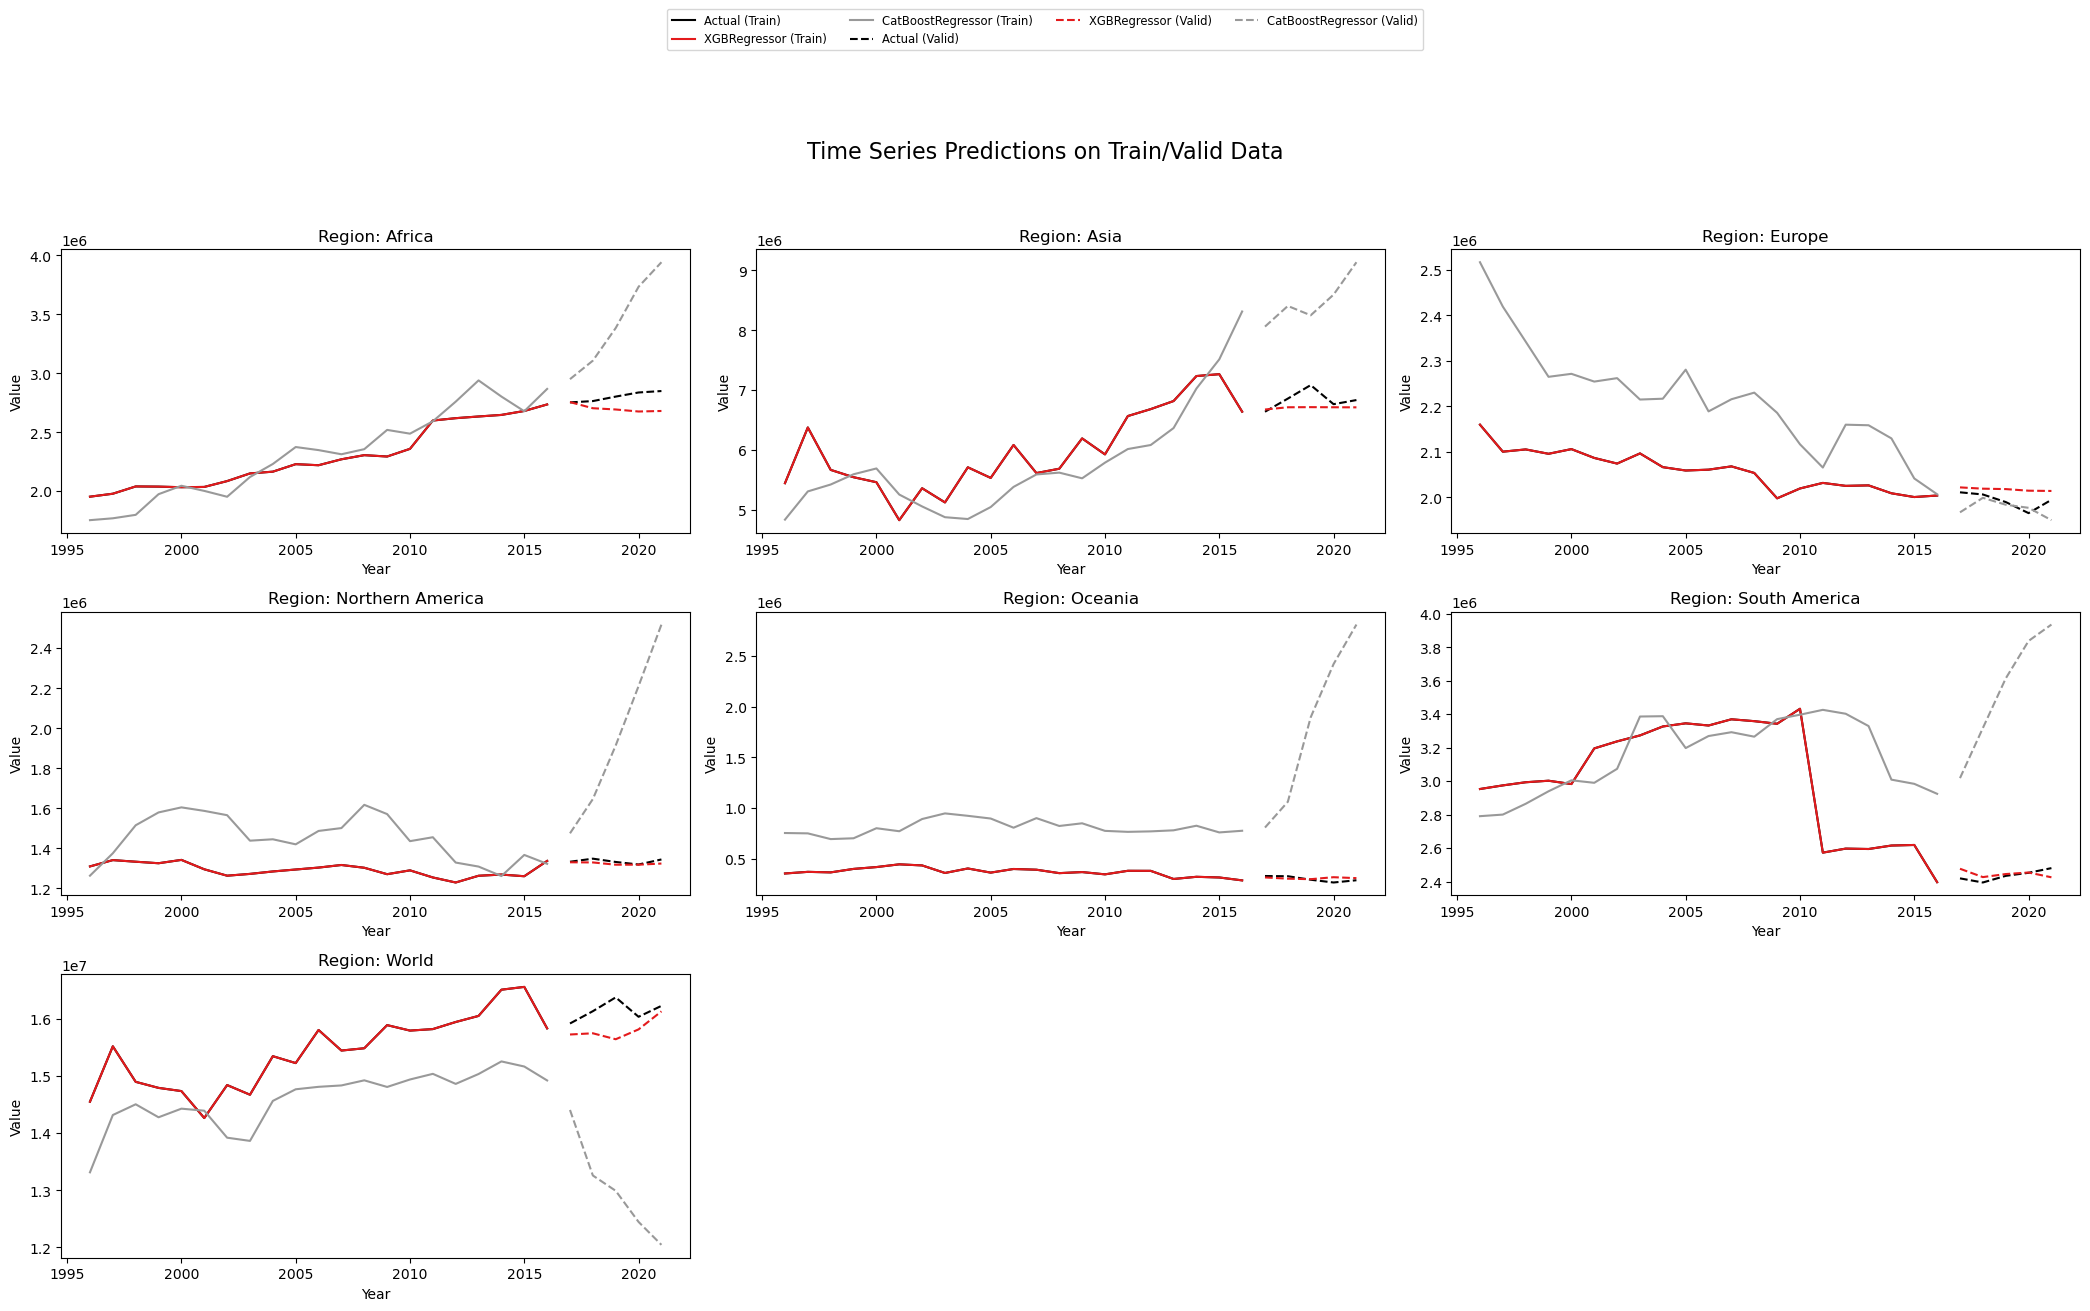

MEAN MAPE_VALID = 50.15%

Model with lowest MAPE validation is XGBRegressor with MAPE = 2.73%

                     MAPE_train  MAPE_valid
XGBRegressor       4.817573e-07    0.027320
CatBoostRegressor  2.415815e-01    0.975639


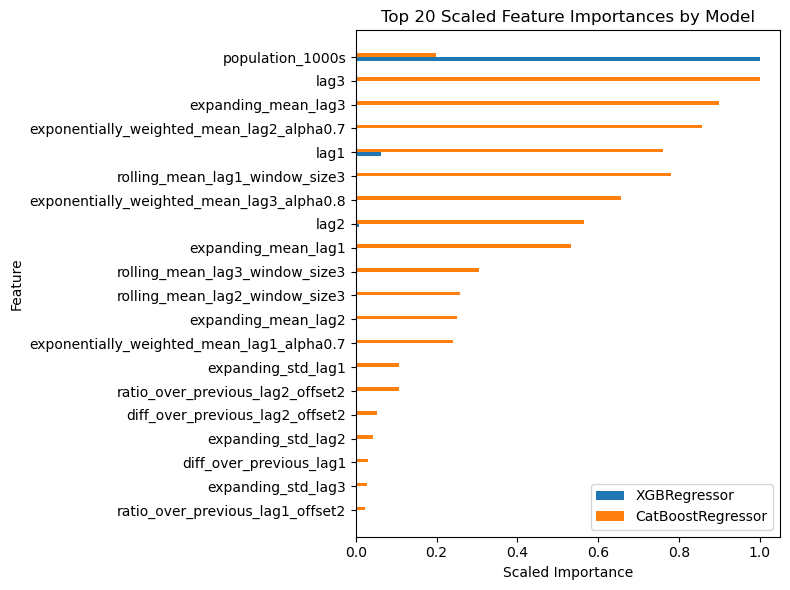

In [258]:
evaluator = MLForecast_Evaluator(fcst, valid, future_df, h=5)

# Plot time series
evaluator.plot_time_series()  # If n_samples is not specified, all time series are plotted

# Calculate and print metrics
evaluator.calculate_metrics()

# Plot feature importances sorted by the average importance
evaluator.plot_feature_importances()

# Predict up to 2030 with full train

In [259]:
future_df_2030 = projections[projections['ds'] <= 2030]
future_df_2030.shape

(567, 3)

In [262]:
full_train = pd.concat([train, valid])

fcst.fit(full_train, fitted=True, static_features=[],
    # prediction_intervals=PredictionIntervals(n_windows=3, h=9, method="conformal_distribution")
    )

MLForecast(models=[XGBRegressor, CatBoostRegressor], freq=1, lag_features=['lag1', 'lag2', 'lag3', 'rolling_mean_lag1_window_size3', 'expanding_mean_lag1', 'exponentially_weighted_mean_lag1_alpha0.7', 'expanding_std_lag1', 'ratio_over_previous_lag1', 'ratio_over_previous_lag1_offset2', 'diff_over_previous_lag1', 'diff_over_previous_lag1_offset2', 'rolling_mean_lag2_window_size3', 'expanding_mean_lag2', 'exponentially_weighted_mean_lag2_alpha0.7', 'expanding_std_lag2', 'ratio_over_previous_lag2', 'ratio_over_previous_lag2_offset2', 'diff_over_previous_lag2', 'diff_over_previous_lag2_offset2', 'rolling_mean_lag3_window_size3', 'expanding_mean_lag3', 'exponentially_weighted_mean_lag3_alpha0.8', 'expanding_std_lag3'], date_features=[], num_threads=6)

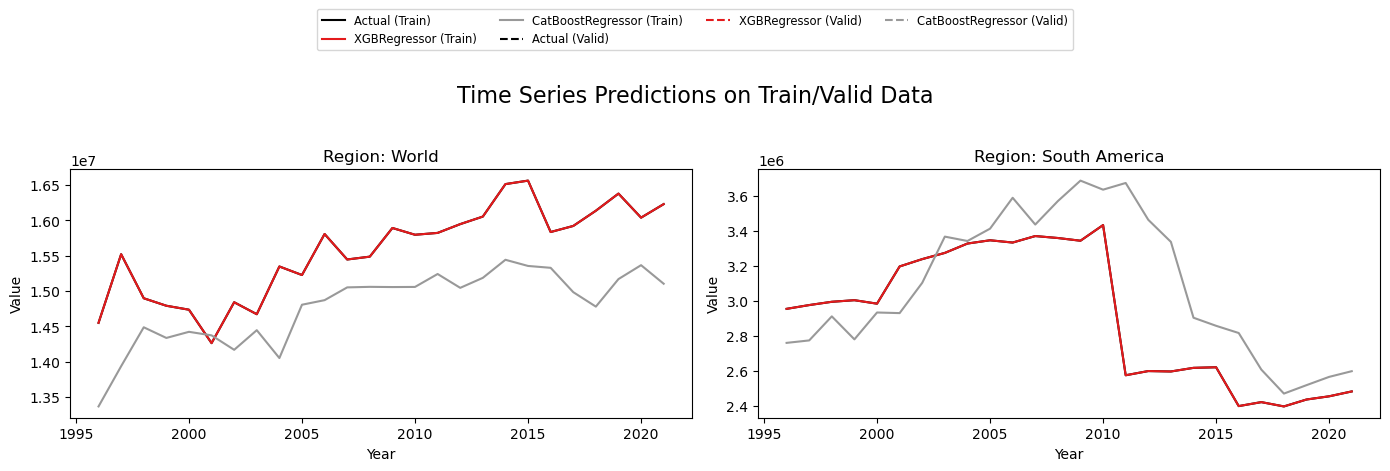

In [263]:
evaluator = MLForecast_Evaluator(fcst, valid, future_df_2030, h=9)

# Plot feature importances sorted by the average importance
evaluator.plot_time_series(n_samples=2)

In [264]:
preds_2030 = fcst.predict(h=9, X_df=future_df_2030, level=[60,80])
preds_2030

,unique_id,ds,XGBRegressor,CatBoostRegressor
0,Africa,2022,2841949.00,3.172431e+06
1,Africa,2023,2852849.75,3.273319e+06
2,Africa,2024,2839286.00,3.537489e+06
3,Africa,2025,2888812.75,4.078737e+06
4,Africa,2026,2847411.50,4.421594e+06
...,...,...,...,...
58,World,2026,16214697.00,1.313893e+07
59,World,2027,16112428.00,1.282868e+07
60,World,2028,16255562.00,1.282672e+07
61,World,2029,16212552.00,1.327739e+07


In [ ]:
def plot_predictions_with_ci(historical_data, forecast_data, 
                             date_col='ds', actual_col='y', 
                             model='XGBRegressor',
                             ci='80',
                             ci2=None,
                             log_y = False,
                             target='Target',
                             region='World'):
    """
    Create a plot of historical data, forecasts, and confidence interval(s).
    
    Parameters:
    - historical_data (pd.DataFrame): DataFrame containing historical data
    - forecast_data (pd.DataFrame): DataFrame containing forecast data and CI
    - date_col (str): Name of the date column
    - actual_col (str): Name of the column with actual values
    - model (str): Name of the model used for predictions
    - ci (str): First confidence interval percentage (e.g., '80' for 80% CI)
    - ci2 (str, optional): Second confidence interval percentage (e.g., '60' for 60% CI)
    - target (str): Name of the target variable
    - region (str): Name of the region being forecasted
    """
    
    ci_low_col = f"{model}-lo-{ci}"
    ci_high_col = f"{model}-hi-{ci}"
    ci_label = f"{ci}% Confidence Interval"

    plt.figure(figsize=(6, 4))
    
    # Plot actual values
    sns.lineplot(x=date_col, y=actual_col, data=historical_data, label="Actual", color='black')
    
    # Plot predictions
    sns.lineplot(x=date_col, y=model, data=forecast_data, label="Prediction", color='darkred')
    
    # Plot first confidence interval as shaded area
    plt.fill_between(forecast_data[date_col], 
                     forecast_data[ci_low_col], 
                     forecast_data[ci_high_col], 
                     alpha=0.3, label=ci_label, color='red')
    
    # Plot second confidence interval if provided
    if ci2:
        ci2_low_col = f"{model}-lo-{ci2}"
        ci2_high_col = f"{model}-hi-{ci2}"
        ci2_label = f"{ci2}% Confidence Interval"
        plt.fill_between(forecast_data[date_col], 
                         forecast_data[ci2_low_col], 
                         forecast_data[ci2_high_col], 
                         alpha=0.15, label=ci2_label, color='blue')
    
    # Customize the plot
    plt.title(f"{target} Predictions for {region}")
    plt.xlabel("Year")
    plt.ylabel(target)
    if log_y:
        plt.yscale('log')
    plt.legend(loc='upper left')
    
     # Ensure the directory exists
    os.makedirs("../plots/forecasts", exist_ok=True)
    
    # Save the plot
    plt.savefig(f"../plots/forecasts/{target}_predictions_{region}.png", dpi=300, bbox_inches='tight')
    
    # Show the plot
    plt.tight_layout()
    plt.show()
    
    print(f"Plot saved as ../plots/forecasts/{target}_predictions_{region}.png")

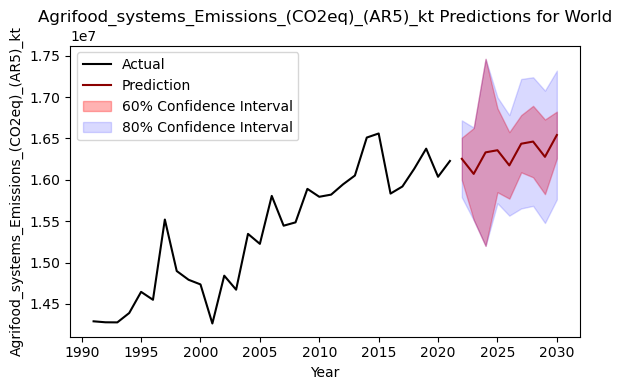

Plot saved as ../plots/forecasts/Agrifood_systems_Emissions_(CO2eq)_(AR5)_kt_predictions_World.png


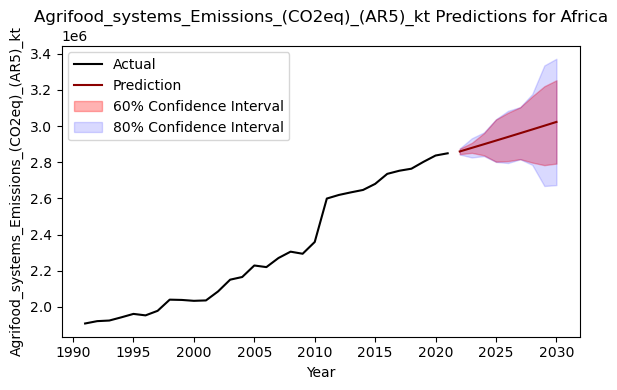

Plot saved as ../plots/forecasts/Agrifood_systems_Emissions_(CO2eq)_(AR5)_kt_predictions_Africa.png


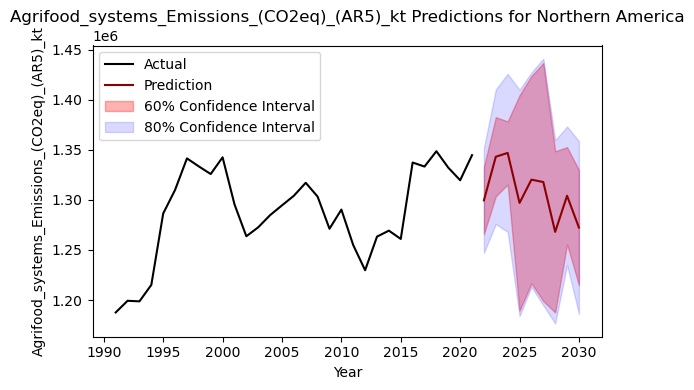

Plot saved as ../plots/forecasts/Agrifood_systems_Emissions_(CO2eq)_(AR5)_kt_predictions_Northern America.png


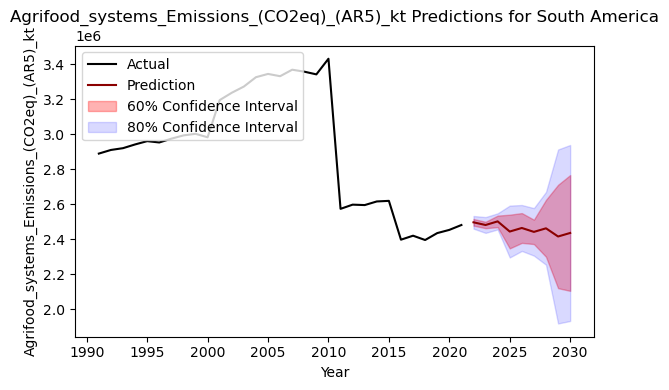

Plot saved as ../plots/forecasts/Agrifood_systems_Emissions_(CO2eq)_(AR5)_kt_predictions_South America.png


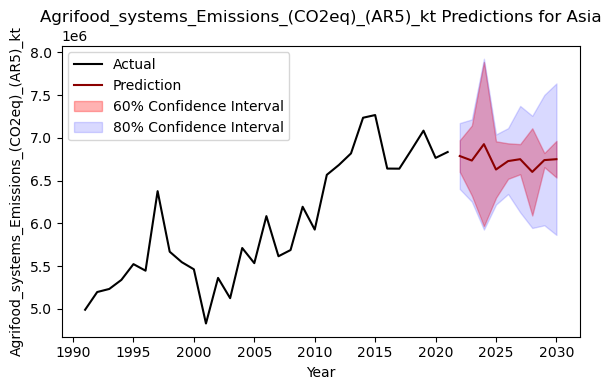

Plot saved as ../plots/forecasts/Agrifood_systems_Emissions_(CO2eq)_(AR5)_kt_predictions_Asia.png


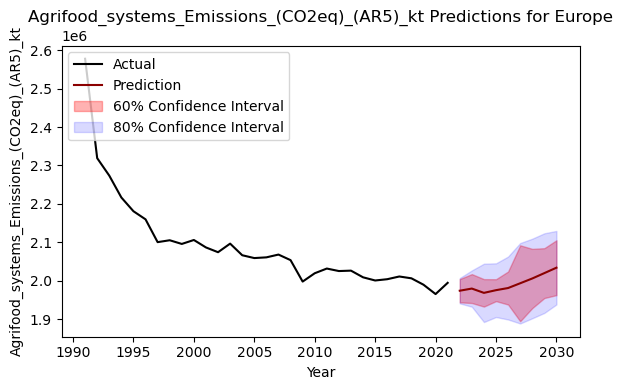

Plot saved as ../plots/forecasts/Agrifood_systems_Emissions_(CO2eq)_(AR5)_kt_predictions_Europe.png


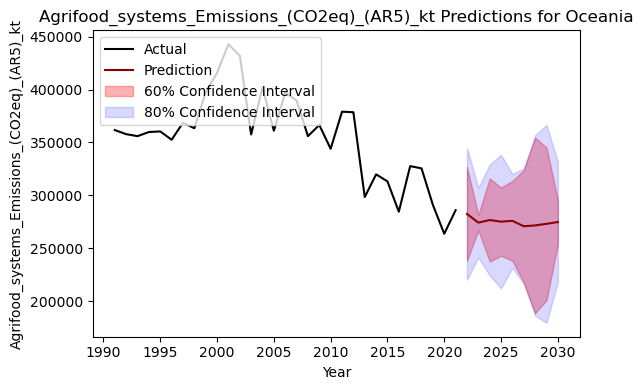

Plot saved as ../plots/forecasts/Agrifood_systems_Emissions_(CO2eq)_(AR5)_kt_predictions_Oceania.png


In [ ]:
for region in full_train['unique_id'].unique():
    plot_data = full_train[full_train['unique_id'] == region]
    future_data = preds_2030[preds_2030['unique_id'] == region]

    plot_predictions_with_ci(plot_data, future_data, date_col='ds', actual_col='y', 
                                model='XGBRegressor', ci='60', ci2='80', target=target, region=region)

# Changes in emissions for the future as percentage

In [ ]:
def percentage_change(df, x1, x2):
    # Filter the dataframe for the two specified years
    df_x1 = df[df['ds'] == x1].set_index('unique_id')['y']
    df_x2 = df[df['ds'] == x2].set_index('unique_id')['y']
    
    # Calculate the percentage change
    pct_change = ((df_x2 - df_x1) / df_x1) * 100
    
    # Print the results with values in gigatonnes and separators
    for unique_id in pct_change.index:
        y1_gigatonnes = df_x1[unique_id] / 1e6
        y2_gigatonnes = df_x2[unique_id] / 1e6
        change = pct_change[unique_id]
        print(f"{unique_id} Region:\n"
              f"  {x1} Value: {y1_gigatonnes:.2f} Gt of CO2\n"
              f"  {x2} Value: {y2_gigatonnes:.2f} Gt of CO2\n"
              f"  Percentage Change: {change:.2f}%\n"
              "-----------------------------------")

In [ ]:
df_with_preds = pd.concat([full_train.iloc[:, :3], preds_2030.iloc[:, :3].rename(columns={"XGBRegressor": "y"})])

In [ ]:
print(("Forecasted Percentage Change in Total Emissions from Agrifood Systems from 2021 to 2030").upper(), "\n")
percentage_change(df_with_preds, 2021, 2030)

FORECASTED PERCENTAGE CHANGE IN TOTAL EMISSIONS FROM AGRIFOOD SYSTEMS FROM 2021 TO 2030 

Africa Region:
  2021 Value: 2.85 Gt of CO2
  2030 Value: 3.02 Gt of CO2
  Percentage Change: 6.09%
-----------------------------------
Asia Region:
  2021 Value: 6.83 Gt of CO2
  2030 Value: 6.75 Gt of CO2
  Percentage Change: -1.23%
-----------------------------------
Europe Region:
  2021 Value: 1.99 Gt of CO2
  2030 Value: 2.03 Gt of CO2
  Percentage Change: 1.97%
-----------------------------------
Northern America Region:
  2021 Value: 1.34 Gt of CO2
  2030 Value: 1.27 Gt of CO2
  Percentage Change: -5.38%
-----------------------------------
Oceania Region:
  2021 Value: 0.29 Gt of CO2
  2030 Value: 0.27 Gt of CO2
  Percentage Change: -3.91%
-----------------------------------
South America Region:
  2021 Value: 2.48 Gt of CO2
  2030 Value: 2.44 Gt of CO2
  Percentage Change: -1.83%
-----------------------------------
World Region:
  2021 Value: 16.23 Gt of CO2
  2030 Value: 16.54 Gt of CO2
